In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some basic plotting styles
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the datasets
# Note: We use relative paths from the root of the project
try:
    train_df = pd.read_csv('../data/train.csv', low_memory=False)
    store_df = pd.read_csv('../data/store.csv')
except FileNotFoundError:
    print("File not found. Make sure train.csv and store.csv are in the 'data' folder.")

# Merge the train and store data
df = pd.merge(train_df, store_df, on='Store')

# Show the first 5 rows to make sure it loaded correctly
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
# --- 1. Handle Date and Sort ---
# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date (important for time series)
df.sort_values(by='Date', inplace=True)

# --- 2. Filter Data ---
# Let's filter for a single store (e.g., Store 1) to start.
# Forecasting for all 1,115 stores at once is complex.
# We will build a model for just one store.
df_store1 = df[df['Store'] == 1].copy()

# Filter out days the store was closed (Sales = 0)
# These days don't have a pattern for the model to learn
df_store1 = df_store1[df_store1['Sales'] > 0]

# --- 3. Set Index ---
# Set the 'Date' as the index of the dataframe
df_store1.set_index('Date', inplace=True)

# Check the first 5 rows of our new, clean dataframe
print(f"Total rows for Store 1: {len(df_store1)}")
df_store1.head()

Total rows for Store 1: 781


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-03,1,4,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-04,1,5,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-05,1,6,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2013-01-07,1,1,7176,785,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


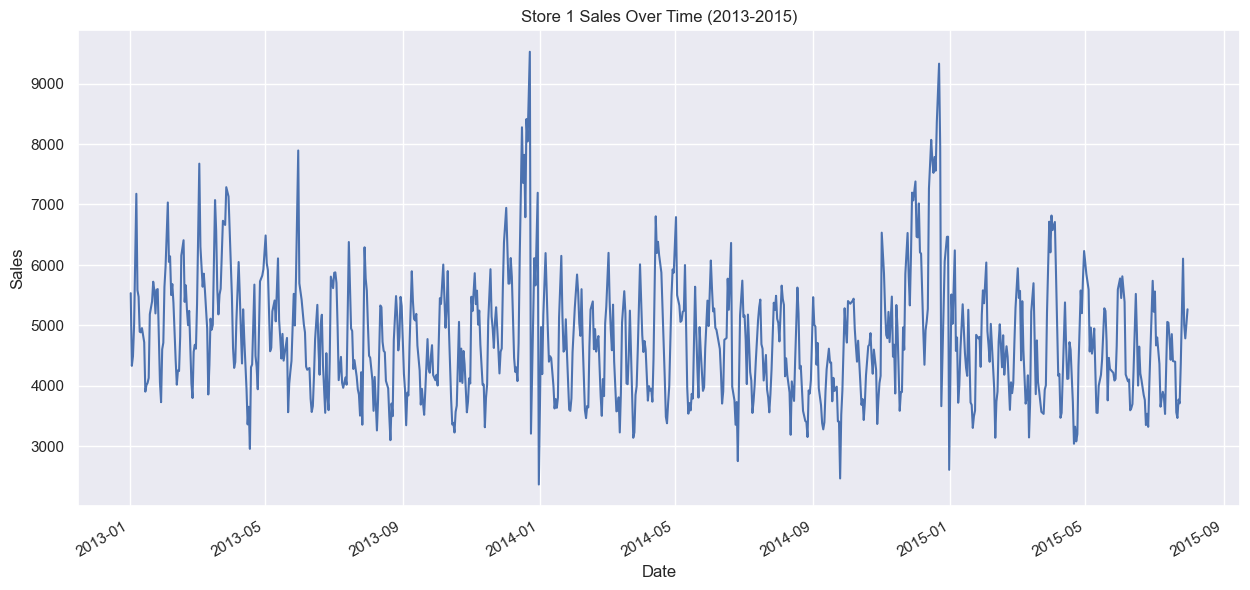

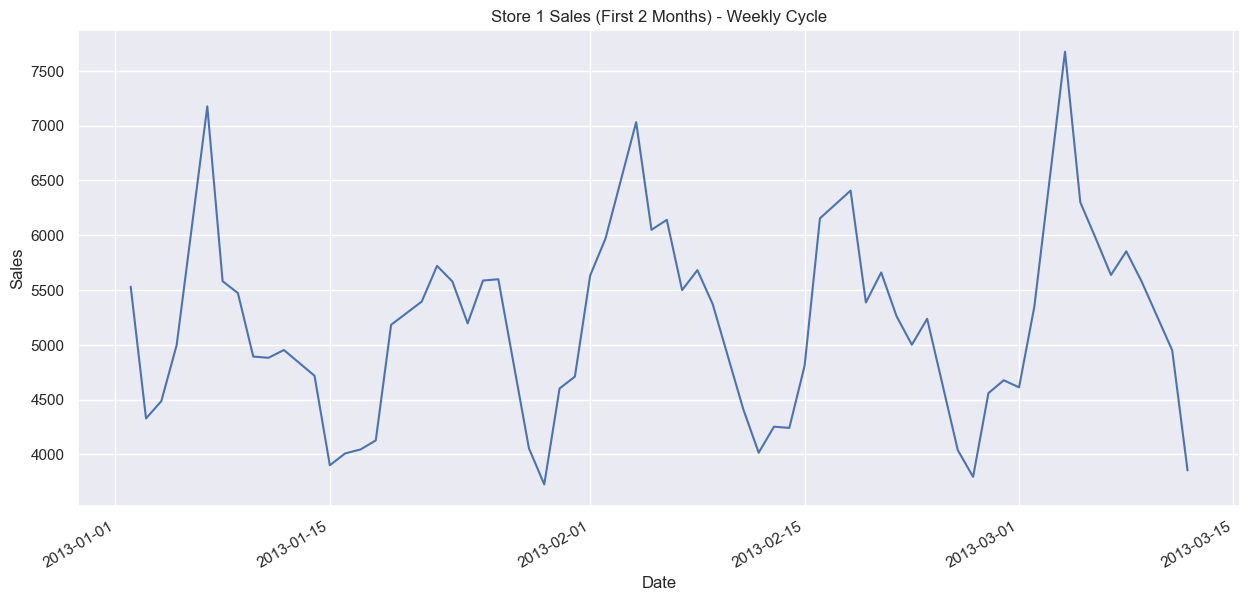

In [4]:
# --- 1. Plot the full time series ---
plt.figure(figsize=(15, 7))
df_store1['Sales'].plot()
plt.title('Store 1 Sales Over Time (2013-2015)')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

# --- 2. Plot a zoomed-in view (e.g., first 2 months) ---
plt.figure(figsize=(15, 7))
df_store1['Sales'].iloc[:60].plot() # Plot the first 60 open days
plt.title('Store 1 Sales (First 2 Months) - Weekly Cycle')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

In [5]:
# Create a new dataframe for our model
model_df = df_store1.copy()

# --- Feature Engineering ---

# 1. StateHoliday: Convert '0' (string) to 0 (number)
# This is to separate "No Holiday" (0) from "a, b, c" holidays
model_df['StateHoliday'] = model_df['StateHoliday'].replace('0', 0)
model_df['StateHoliday'] = model_df['StateHoliday'].replace(0, 'NoHoliday')

# 2. One-Hot Encode StateHoliday
# This creates new columns: StateHoliday_a, StateHoliday_b, etc.
model_df = pd.get_dummies(model_df, columns=['StateHoliday'], drop_first=True)

# 3. Define our variables
# 'y' is the target variable we want to forecast
y = model_df['Sales']

# 'X' are the external "helper" variables
# We select all the new columns we just made
exog_cols = ['Promo', 'SchoolHoliday'] + [col for col in model_df.columns if col.startswith('StateHoliday_')]
X = model_df[exog_cols]

# Check the first 5 rows of our new 'X' features
X.head()

/var/folders/1y/pn9x7lqd0vj4j9d589w2jl1r0000gn/T/ipykernel_10773/2396380258.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df['StateHoliday'] = model_df['StateHoliday'].replace('0', 0)


,Promo,SchoolHoliday
Date,,
2013-01-02,0,1
2013-01-03,0,1
2013-01-04,0,1
2013-01-05,0,1
2013-01-07,1,1


In [6]:
from pmdarima import auto_arima

# --- Find the best SARIMAX model ---
# This will search for the best (p,d,q)(P,D,Q,m) orders
# m=7 tells it to look for a 7-day (weekly) seasonal cycle
# trace=True will print out the results of each model it tries

print("Starting model search... (This may take a few minutes)")

# We use 'X' here, which in pmdarima is called 'exogenous'
auto_model = auto_arima(
    y,                      # Our 'Sales' data
    exogenous=X,            # Our 'Promo' and 'SchoolHoliday' data
    m=7,                    # The 7-day weekly cycle
    seasonal=True,          # We MUST have a seasonal component
    stepwise=True,          # This speeds up the search
    suppress_warnings=True, # Ignore warnings
    trace=True,             # Print out the results as it works
    error_action='ignore'   # Skip models that fail
)

# Print the final summary of the best model
print(auto_model.summary())

Starting model search... (This may take a few minutes)
Performing stepwise search to minimize aic


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=12508.185, Time=1.57 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13028.092, Time=0.02 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12534.836, Time=0.27 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=12731.233, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=15479.610, Time=0.01 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=12522.839, Time=0.57 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=12524.727, Time=1.35 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=12505.138, Time=3.18 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=12526.617, Time=2.20 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=12507.197, Time=4.17 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=12505.118, Time=3.18 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=12524.536, Time=1.35 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=12543.737, Time=3.22 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=12523.617, Time=3.01 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,2)[7] intercept   : AIC=12507.221, Time=4.60 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,2)[7] intercept   : AIC=12516.487, Time=5.02 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=12538.729, Time=2.28 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,2)[7] intercept   : AIC=12541.870, Time=3.78 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[7] intercept   : AIC=12512.060, Time=3.51 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,2)[7] intercept   : AIC=12504.939, Time=4.27 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,2)[7] intercept   : AIC=12493.863, Time=2.00 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,1)[7] intercept   : AIC=12492.834, Time=0.93 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[7] intercept   : AIC=12500.789, Time=0.33 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,1)[7] intercept   : AIC=12502.219, Time=2.16 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,0)[7] intercept   : AIC=12529.693, Time=1.65 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[7] intercept   : AIC=12496.178, Time=0.48 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=12513.060, Time=0.83 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,1)[7] intercept   : AIC=12493.080, Time=1.83 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,1)[7] intercept   : AIC=12484.787, Time=1.12 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[7] intercept   : AIC=12482.838, Time=0.56 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(1,0,0)[7] intercept   : AIC=12475.736, Time=1.83 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(2,0,0)[7] intercept   : AIC=12477.884, Time=4.20 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(2,0,1)[7] intercept   : AIC=inf, Time=4.91 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(1,0,0)[7] intercept   : AIC=12500.830, Time=1.61 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(1,0,0)[7] intercept   : AIC=12494.668, Time=2.32 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(1,0,0)[7] intercept   : AIC=12480.647, Time=2.17 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[7] intercept   : AIC=12540.715, Time=1.49 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,5)(1,0,0)[7] intercept   : AIC=12480.406, Time=1.84 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(1,0,0)[7] intercept   : AIC=12518.024, Time=2.38 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(1,0,0)[7] intercept   : AIC=12495.653, Time=2.47 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(1,0,0)[7]             : AIC=12780.224, Time=1.42 sec

Best model:  ARIMA(3,0,4)(1,0,0)[7] intercept
Total fit time: 87.618 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  781
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 7)   Log Likelihood               -6227.868
Date:                            Wed, 22 Oct 2025   AIC                          12475.736
Time:                                    01:05:10   BIC                          12522.342
Sample:                                         0   HQIC                         12493.660
                                            - 781                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [7]:
# --- 11. Train/Test Split ---
# For time series, we MUST split by date. We can't shuffle.
# We'll use the last 30 open days as our test set.
test_period = 30
train_size = len(y) - test_period

# Split our y (target) and X (features)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

print(f"Training data size: {len(y_train)} points")
print(f"Test data size:     {len(y_test)} points")

Training data size: 751 points
Test data size:     30 points


In [8]:
import statsmodels.api as sm

# --- 12. Train the Final Model ---
# We use the 'best' orders found by auto_arima
# Best model:  ARIMA(3,0,4)(1,0,0)[7]

# Define the model orders
my_order = (3, 0, 4)           # (p, d, q)
my_seasonal_order = (1, 0, 0, 7) # (P, D, Q, m)

# Create the SARIMAX model
final_model = sm.tsa.SARIMAX(
    endog=y_train,        # The 'y' (target) training data
    exog=X_train,         # The 'X' (helper) training data
    order=my_order,
    seasonal_order=my_seasonal_order
)

# Fit (train) the model
# This may take 30-60 seconds
print("Training the final model...")
model_fit = final_model.fit(disp=False) # disp=False hides the long convergence log
print("Model training complete.")

# Print the model summary
print(model_fit.summary())

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Training the final model...
Model training complete.
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  751
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 7)   Log Likelihood               -6700.514
Date:                            Wed, 22 Oct 2025   AIC                          13423.028
Time:                                    01:09:41   BIC                          13473.864
Sample:                                         0   HQIC                         13442.615
                                            - 751                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo          4755.5592    150.918     31.511      0.0

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# --- 13. Re-run auto_arima to find a STABLE model ---
# Our last model was too complex and failed to converge.
# Let's find a simpler one by limiting the 'p' and 'q' values.
# We set max_p=3 and max_q=3 to limit the complexity.

print("Starting a *simpler* model search...")

auto_model_simple = auto_arima(
    y,
    exogenous=X,
    m=7,
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    
    # --- This is the new, important part ---
    max_p=3,  # Don't try 'p' values higher than 3
    max_q=3,  # Don't try 'q' values higher than 3
    max_P=2,  # Don't try 'P' values higher than 2
    max_Q=2   # Don't try 'Q' values higher than 2
)

# Print the new best model
print(auto_model_simple.summary())

Starting a *simpler* model search...
Performing stepwise search to minimize aic


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=12508.185, Time=1.53 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13028.092, Time=0.02 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12534.836, Time=0.27 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=12731.233, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=15479.610, Time=0.01 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=12522.839, Time=0.58 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=12524.727, Time=1.34 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=12505.138, Time=3.17 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=12526.617, Time=2.20 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=12507.197, Time=4.14 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=12505.118, Time=3.29 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=12524.536, Time=1.47 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=12543.737, Time=3.20 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=12523.617, Time=3.10 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,2)[7] intercept   : AIC=12507.221, Time=4.68 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,2)[7] intercept   : AIC=12516.487, Time=4.98 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=12538.729, Time=2.31 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,2)[7] intercept   : AIC=12541.870, Time=3.78 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[7] intercept   : AIC=12512.060, Time=3.54 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,2)[7] intercept   : AIC=12504.939, Time=4.28 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,2)[7] intercept   : AIC=12493.863, Time=2.01 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,1)[7] intercept   : AIC=12492.834, Time=0.97 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[7] intercept   : AIC=12500.789, Time=0.33 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,1)[7] intercept   : AIC=12502.219, Time=2.11 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,0)[7] intercept   : AIC=12529.693, Time=1.66 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[7] intercept   : AIC=12496.178, Time=0.50 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=12513.060, Time=0.83 sec


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,1)[7]             : AIC=12512.043, Time=1.15 sec

Best model:  ARIMA(3,0,3)(0,0,1)[7] intercept
Total fit time: 57.826 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  781
Model:             SARIMAX(3, 0, 3)x(0, 0, [1], 7)   Log Likelihood               -6237.417
Date:                             Wed, 22 Oct 2025   AIC                          12492.834
Time:                                     01:12:53   BIC                          12534.779
Sample:                                          0   HQIC                         12508.966
                                             - 781                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [10]:
# --- 14. Train the FINAL STABLE Model ---
# We're using the new, stable orders from our second search.
# New Best model: ARIMA(3,0,3)(0,0,1)[7]

# Define the new, stable model orders
my_order = (3, 0, 3)           # (p, d, q)
my_seasonal_order = (0, 0, 1, 7) # (P, D, Q, m)

# Create the SARIMAX model
final_model_stable = sm.tsa.SARIMAX(
    endog=y_train,        # The 'y' (target) training data
    exog=X_train,         # The 'X' (helper) training data
    order=my_order,
    seasonal_order=my_seasonal_order
)

# Fit (train) the model
print("Training the final, stable model...")
model_fit_stable = final_model_stable.fit(disp=False) # disp=False hides the log
print("Model training complete.")

# Print the model summary
print(model_fit_stable.summary())

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/si

Training the final, stable model...
Model training complete.
                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  751
Model:             SARIMAX(3, 0, 3)x(0, 0, [1], 7)   Log Likelihood               -6697.786
Date:                             Wed, 22 Oct 2025   AIC                          13415.571
Time:                                     01:13:59   BIC                          13461.785
Sample:                                          0   HQIC                         13433.377
                                             - 751                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo          4756.1654    152.351    

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# --- 15. Train a SIMPLE, STABLE Model ---
# The (3,0,3) model was too complex and failed to converge.
# We will manually override this with a much simpler, common, and
# more stable model: (1, 0, 1).

# Define the new, stable model orders
my_order = (1, 0, 1)           # (p, d, q) - Our new simple model
my_seasonal_order = (0, 0, 1, 7) # (P, D, Q, m) - The seasonal part that worked

# Create the SARIMAX model
final_model_simple = sm.tsa.SARIMAX(
    endog=y_train,        # The 'y' (target) training data
    exog=X_train,         # The 'X' (helper) training data
    order=my_order,
    seasonal_order=my_seasonal_order
)

# Fit (train) the model
print("Training the final, *simple* model...")
model_fit_simple = final_model_simple.fit(disp=False)
print("Model training complete.")

# Print the model summary
print(model_fit_simple.summary())

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Training the final, *simple* model...
Model training complete.
                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  751
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -6202.604
Date:                           Wed, 22 Oct 2025   AIC                          12417.207
Time:                                   01:15:16   BIC                          12444.936
Sample:                                        0   HQIC                         12427.891
                                           - 751                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo           -94.5058    126.506     -0.747      0

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# --- 16. Train a DIFFERENCED Model to Fix Instability ---
#
# Our model is unstable because the 'ar.L1' term is ~1 (a "unit root").
# The correct fix is to add differencing (d=1). This is the 'I' in ARIMA.
# We will now model the *change* in sales, not the sales level.
#

# Define the new, stable model orders
my_order = (1, 1, 1)           # (p, d, q) <-- Note: d is now 1
my_seasonal_order = (0, 0, 1, 7) # (P, D, Q, m)

# Create the SARIMAX model
final_model_diff = sm.tsa.SARIMAX(
    endog=y_train,        # The 'y' (target) training data
    exog=X_train,         # The 'X' (helper) training data
    order=my_order,
    seasonal_order=my_seasonal_order
)

# Fit (train) the model
print("Training the final *differenced* (d=1) model...")
model_fit_diff = final_model_diff.fit(disp=False)
print("Model training complete.")

# Print the model summary
print(model_fit_diff.summary())

/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Training the final *differenced* (d=1) model...
Model training complete.
                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  751
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood               -5981.452
Date:                           Wed, 22 Oct 2025   AIC                          11974.904
Time:                                   01:15:57   BIC                          12002.625
Sample:                                        0   HQIC                         11985.586
                                           - 751                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo           578.9064     65.438      8.

In [13]:
# --- 17. Make Predictions on the Test Set ---

# We want to forecast for the same number of days as our test set (30 days)
num_steps = len(y_test)

# We MUST provide the 'exog' (our X features) for the future period
# This is our X_test dataframe
predictions = model_fit_diff.forecast(
    steps=num_steps,
    exog=X_test
)

# Rename the predictions Series for easy plotting
predictions = predictions.rename('SARIMAX Predictions')

# Print the first 5 predictions
print(predictions.head())


751    3638.641814
752    4365.305680
753    4472.697770
754    4530.040384
755    4582.427095
Name: SARIMAX Predictions, dtype: float64


/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/narendersingh/Desktop/stuff/repos/rossmann-store-sales/ross/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


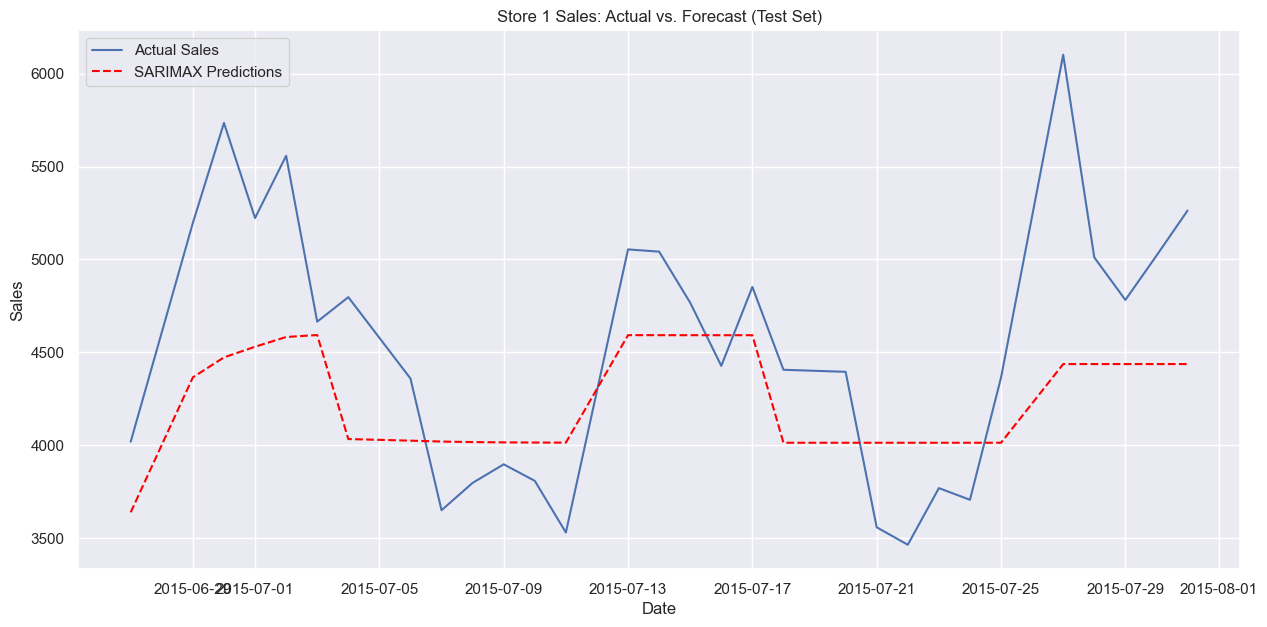

In [15]:
# --- 18. (Revised) - Fix Index and Plot Predictions ---

# 1. THE FIX:
# Force the predictions to use the same date index as the test set.
# This aligns them perfectly for plotting.
predictions.index = y_test.index

# 2. THE PLOT (Same as before):
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Sales')
plt.plot(predictions, label='SARIMAX Predictions', color='red', linestyle='--')

plt.title('Store 1 Sales: Actual vs. Forecast (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
import math

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate the Root Mean Squared Error (RMSE)
rmse = math.sqrt(mse)

print(f"Model Accuracy (RMSE): {rmse}")

Model Accuracy (RMSE): 603.0296357129463


In [18]:
# --- 19. Calculate the Official Competition Score (RMSPE) ---

# Make sure we don't have any zero sales in our test set (which we shouldn't)
# This will prevent a "divide by zero" error
if (y_test == 0).any():
    print("Warning: Test data contains 0 sales. RMSPE will be incorrect.")

# Calculate RMSPE
# 1. (y_test - predictions) / y_test   <-- Percentage Error
# 2. (...)**2                          <-- Squared
# 3. np.mean(...)                      <-- Mean
# 4. np.sqrt(...)                      <-- Root
rmspe = np.sqrt(np.mean(((y_test - predictions) / y_test) ** 2))

# Multiply by 100 to make it an easy-to-read percentage
print(f"Model Accuracy (RMSPE): {rmspe * 100:.2f}%")

Model Accuracy (RMSPE): 11.92%
